# Vignetting analysis for EPIC

This analysis follows on a couple of early studies:

* Statistical evaluation of the flux cross-calibration of the XMM-EPIC ([Mateos et al. 2009](https://ui.adsabs.harvard.edu/abs/2009A%26A...496..879M/abstract));
* The non-linear X-ray/UV relation in AGNs: contribution of instrumental effects on the X-ray variability ([Elisabeta Lusso, 2018](https://ui.adsabs.harvard.edu/abs/2019AN....340..267L/abstract)).


**NOTES:** 
1. This notebook will read the 3XMM-DR8 catalogue with the added azymuthal angle from my calculations.
2. In this notebook (`work4`) all the analysis is based on sources detected at MOS1 off-axis angles greater than 2 arcmin. In notebook `work3` the analysis is using all off-axis angles, except for the azymuthal dependence.

_20 Aug 2019_

In [1]:
import os

import numpy as np
from scipy.stats import norm, sem
from statsmodels.stats.weightstats import DescrStatsW

from astropy.table import Table
import pandas as pd
#import altair as alt

%matplotlib inline
import matplotlib.pylab as plt
import matplotlib.mlab as mlab
import matplotlib.cm as cm
#
import seaborn as sns
sns.set(style="white")

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

home = os.path.expanduser('~')

## Energy bands used in 3XMM

```Basic energy bands: 	
1 	= 	0.2 -   0.5 keV 	 
2 	= 	0.5 -   1.0 keV 	  	 
3 	= 	1.0 -   2.0 keV 	  	 
4 	= 	2.0 -   4.5 keV 	  	 
5 	= 	4.5 - 12.0 keV 	  	 
Broad energy bands: 	
6 	= 	0.2 -   2.0 keV 	  	soft band, no images made, not used
7 	= 	2.0 - 12.0 keV 	  	hard band, no images made, not used
8 	= 	0.2 - 12.0 keV 	  	total band
9 	= 	0.5 -   4.5 keV 	  	XID band
```

In [115]:
#
# define the energy ranges for info
#
bands = {1:'[0.2-0.5] keV',2:'[0.5-1.0] keV',3:'[1.0-2.0] keV',4:'[2.0-4.5] keV',5:'[4.5-12.0] keV',\
        8:'[0.2-12.0] keV'}

In [3]:
#
# read the 3XMM-DR8 catalogue
#
wdir = f"{home}/XMM/3XMM"
#t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.0.fits.gz')
#
# my version with the azymuthal angle for the detections
#
t3 = Table.read(f'{wdir}/3XMM_DR8cat_v1.1_azymuth.fits.gz')

## Source selection

We apply the following selection of sources from the `3XMM-DR8` catalogue, where `x` is one of `M1, M2` or `PN`:
1. good detection, i.e. `SUM_FLAG == 0`
2. point-like sources, i.e. `EP_EXTENT == 0`
3. at off-axis angles <= 12 arcmin, i.e. `x_OFFAX <= 12` and `M1_OFFAX >= 2.0`
4. flux in [2,12] keV <= 6.0e-12 erg/cm2/s, i.e. `(x_4_FLUX + x_5_FLUX) <= 6.0e-12`, in order to avoid pile-up sources.
5. `CONFUSED == false`
6. `HIGH_BACKGROUND == false`
7. at least 200 source counts in band 8, i.e. `EP_8_CTS >= 200`
8. not too faint sources, i.e. `x_5_FLUX >= 1.0e-15`
9. High SNR in band 5, i.e. `x_5_FLUX/x_5_FLUX_ERR >= 5`

In [4]:
ntot = len(t3)
m1 = t3['SUM_FLAG'] == 0
#
m2 = t3['EP_EXTENT'] == 0
#
m3_m1 = t3['M1_OFFAX'] <= 12.0
m3_m1x = t3['M1_OFFAX'] >= 2.0
#
m3_m2 = t3['M2_OFFAX'] <= 12.0
m3_pn = t3['PN_OFFAX'] <= 12.0
#
m4_m1 = (t3['M1_4_FLUX'] + t3['M1_5_FLUX']) <= 6.0e-12
m4_m2 = (t3['M2_4_FLUX'] + t3['M2_5_FLUX']) <= 6.0e-12
m4_pn = (t3['PN_4_FLUX'] + t3['PN_5_FLUX']) <= 6.0e-12
#
m5 = t3['CONFUSED'] == 0
#
m6 = t3['HIGH_BACKGROUND'] == 0
#
m7 = t3['EP_8_CTS'] >= 200.0
#
m8_m1 = (t3['M1_5_FLUX']) >= 1.0e-15
m8_m2 = (t3['M2_5_FLUX']) >= 1.0e-15
m8_pn = (t3['PN_5_FLUX']) >= 1.0e-15
#
m9_m1 = (t3['M1_5_FLUX']/t3['M1_5_FLUX_ERR']) >= 5.0
m9_m2 = (t3['M2_5_FLUX']/t3['M2_5_FLUX_ERR']) >= 5.0
m9_pn = (t3['PN_5_FLUX']/t3['PN_5_FLUX_ERR']) >= 5.0
#
#xfilter = m1*m2*m3_m1*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7*m8_m1*m8_m2*m8_pn*m9_m1*m9_m2*m9_pn
xfilter = m1*m2*m3_m1*m3_m1x*m3_m2*m3_pn*m4_m1*m4_m2*m4_pn*m5*m6*m7
#
ix = np.where(xfilter)[0]
nx = len(ix)
print (f"Found {nx} out of {ntot} ({100*nx/ntot:.2f} %) 3XMM-DR8 sources with the filtering criteria.")

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in less_equal
  return getattr(self.data, op)(other)
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/astropy/table/column.py:981: RuntimeWarning: invalid value encountered in greater_equal
  return getattr(self.data, op)(other)


Found 47457 out of 775153 (6.12 %) 3XMM-DR8 sources with the filtering criteria.


In [5]:
#
# extract the selection as a table
#
tsel = t3[ix]

#fig, ax = plt.subplots(figsize=(15,10))
#ax.loglog(tsel['PN_8_CTS'],tsel['M1_5_FLUX']/tsel['PN_5_FLUX'],'bo')
#ax.grid()
#ax.set_xlabel('PN COUNTS in BAND 8')
#ax.set_ylabel('MOS1/PN FLUX BAND 5')
#ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c=".3")
#
# interactive plot with altair
#
# extract some relevant columns
#
xtab = tsel['DETID','SRCID','DR3SRCID',\
            'M1_1_FLUX','M1_2_FLUX','M1_3_FLUX','M1_4_FLUX','M1_5_FLUX',\
            'PN_1_FLUX','PN_2_FLUX','PN_3_FLUX','PN_4_FLUX','PN_5_FLUX',\
            'PN_8_CTS', 'PN_ONTIME', 'M1_ONTIME', 'DIST_NN'].to_pandas()
xtab['ratio_5'] = xtab['M1_5_FLUX']/xtab['PN_5_FLUX']

selector = alt.selection_single(empty='all', fields=['DETID'])

base = alt.Chart(xtab).properties(
    title="3XMM-DR8 counts vs flux ratio",width=800,height=200).add_selection(selector).transform_fold(
    ['M1_1_FLUX','M1_2_FLUX','M1_3_FLUX','M1_4_FLUX','M1_5_FLUX'],
    as_=["bandm","mos1"]).transform_fold(
    ['PN_1_FLUX','PN_2_FLUX','PN_3_FLUX','PN_4_FLUX','PN_5_FLUX'],
    as_=["bandq","pn"])

points = base.mark_point(filled=True, size=50).encode(
    x=alt.X(
        'PN_8_CTS',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(title='PN COUNTS in BAND 8')
    ),
    y=alt.Y(
        'ratio_5',
        scale=alt.Scale(type='log'),
        axis=alt.Axis(title="MOS1/PN FLUX in BAND 5")
    ),
    color=alt.condition(selector, 'DIST_NN', alt.value('lightgray'), legend=None),
    tooltip=['DR3SRCID','PN_5_FLUX','M1_5_FLUX','M1_ONTIME','PN_ONTIME','DIST_NN']
).interactive()

#
# now the SED
sed1 = base.mark_line(point=True).encode(
    x='bandm:N',
    y=alt.Y(
        'fx:Q',
        #scale=alt.Scale(type='log'),
        axis=alt.Axis(title=r'Flux x10^{15}')
   )).transform_calculate(
    fx='datum.mos1*1.0e15').transform_filter(
    selector
    )

sed2 = base.mark_line(point=True).encode(
    x='bandq:N',
    y=alt.Y(
        'fy:Q',
        #scale=alt.Scale(type='log'),
        axis=alt.Axis(title='Flux x10^{-15}')
   )).transform_calculate(
    fy='datum.pn*1.0e15').transform_filter(
    selector
    )

alt.vconcat(points,sed1,sed2)
#sed

## Histograms of MOSx vs PN fluxes, per band

First we filter per band the selected catalogue, to discard too faint sources and sources with SNR (flux/flux_err) lower than 5. The sub-selected per band catalogues are stored in a dict for later use.

There are three ratios: `PN/MOS1 - 1, PN/MOS2 - 1` and `MOS2/MOS1 - 1` for each of the 5 bands.

We calculate the weighted mean and its standard error for each flux ratio and band, using `statsmodels.stats.weightstats.DescrStatsW` for weighted statistics. The weights are `w=1.0/ratio_err`, where `ratio_err` is the error of the ratio taking into account the errors on fluxes.

A normal distribution is also fit to the unbinned ratios and we can use the fitted location and its error, as it was done in Mateos et al. (2009). But the fit does not match well the histograms.

pn vs MOS1 Band 1 ([0.2-0.5] keV): median=-11.9, low(0.16)=-12.3, up(0.84)=-11.5, n=4370
pn vs MOS2 Band 1 ([0.2-0.5] keV): median=-1.4, low(0.16)=-2.0, up(0.84)=-0.9, n=4370
MOS2 vs MOS1 Band 1 ([0.2-0.5] keV): median=-8.2, low(0.16)=-8.7, up(0.84)=-7.7, n=4370
pn vs MOS1 Band 2 ([0.5-1.0] keV): median=-8.9, low(0.16)=-9.1, up(0.84)=-8.6, n=10797
pn vs MOS2 Band 2 ([0.5-1.0] keV): median=-5.2, low(0.16)=-5.4, up(0.84)=-4.9, n=10797
MOS2 vs MOS1 Band 2 ([0.5-1.0] keV): median=-2.1, low(0.16)=-2.4, up(0.84)=-1.8, n=10797
pn vs MOS1 Band 3 ([1.0-2.0] keV): median=-6.0, low(0.16)=-6.2, up(0.84)=-5.8, n=15217
pn vs MOS2 Band 3 ([1.0-2.0] keV): median=-5.6, low(0.16)=-5.8, up(0.84)=-5.4, n=15217
MOS2 vs MOS1 Band 3 ([1.0-2.0] keV): median=1.2, low(0.16)=0.9, up(0.84)=1.4, n=15217


/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/ipykernel_launcher.py:130: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/ipykernel_launcher.py:61: RuntimeWarning: divide by zero encountered in true_divide


pn vs MOS1 Band 4 ([2.0-4.5] keV): median=-9.4, low(0.16)=-9.7, up(0.84)=-9.0, n=7491
pn vs MOS2 Band 4 ([2.0-4.5] keV): median=-7.5, low(0.16)=-7.8, up(0.84)=-7.1, n=7491
MOS2 vs MOS1 Band 4 ([2.0-4.5] keV): median=-0.3, low(0.16)=-0.7, up(0.84)=0.0, n=7491
pn vs MOS1 Band 5 ([4.5-12.0] keV): median=-13.1, low(0.16)=-13.9, up(0.84)=-12.2, n=1289
pn vs MOS2 Band 5 ([4.5-12.0] keV): median=-10.9, low(0.16)=-11.8, up(0.84)=-10.0, n=1289
MOS2 vs MOS1 Band 5 ([4.5-12.0] keV): median=-0.1, low(0.16)=-1.1, up(0.84)=0.8, n=1289


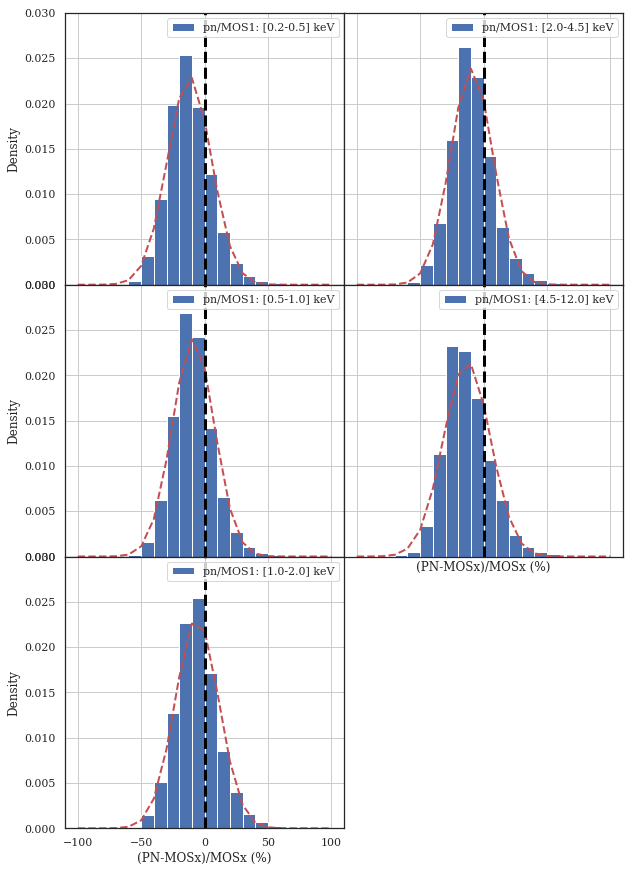

In [6]:
#
# histograms of flux difference (PN-MOS1)/MOS1 in different bands
#
fig, axs = plt.subplots(3,2,figsize=(10,15),sharex=True,sharey=True)

#fig8, ax8 = plt.subplots(figsize=(15,10))

qtsel = {}
med1 = {}
low1 = {}
up1 = {}
med2 = {}
low2 = {}
up2 = {}
med3 = {}
low3 = {}
up3 = {}
#
mean1 = {}
mean2 = {}
mean3 = {}
sem1 = {}
sem2 = {}
sem3 = {}
#
for xband in [1,2,3,4,5]:    
    q1_m1 = (tsel[f'M1_{xband}_FLUX']) >= 1.0e-15
    q1_m2 = (tsel[f'M2_{xband}_FLUX']) >= 1.0e-15
    q1_pn = (tsel[f'PN_{xband}_FLUX']) >= 1.0e-15
    #
    q2_m1 = (tsel[f'M1_{xband}_FLUX']/tsel[f'M1_{xband}_FLUX_ERR']) >= 5.0
    q2_m2 = (tsel[f'M2_{xband}_FLUX']/tsel[f'M2_{xband}_FLUX_ERR']) >= 5.0
    q2_pn = (tsel[f'PN_{xband}_FLUX']/tsel[f'PN_{xband}_FLUX_ERR']) >= 5.0
    #
    qfilter = q1_m1 & q1_m2 & q1_pn & q2_m1 & q2_m2 & q2_pn
    qtsel[xband] = tsel[qfilter]
    nqt = len(qtsel[xband])
    #
    m1_fx = qtsel[xband][f'M1_{xband}_FLUX']
    m2_fx = qtsel[xband][f'M2_{xband}_FLUX']
    pn_fx = qtsel[xband][f'PN_{xband}_FLUX']
    #
    m1_fx_err = qtsel[xband][f'M1_{xband}_FLUX_ERR']
    m2_fx_err = qtsel[xband][f'M2_{xband}_FLUX_ERR']
    pn_fx_err = qtsel[xband][f'PN_{xband}_FLUX_ERR']
    #
    # now the ratios and their errors
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx_err/m1_fx)**2 + (pn_fx_err/pn_fx)**2)
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx_err/m2_fx)**2 + (pn_fx_err/pn_fx)**2)
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx_err/m1_fx)**2 + (m2_fx_err/m2_fx)**2)
    #
    # the weights as 1/sigma
    #
    w1 = 1.0/ratio1_err
    #print (f'Band: {xband}, minmax weights1: ',np.min(w1),np.max(w1))
    w2 = 1.0/ratio2_err
    w3 = 1.0/ratio3_err
    #
    #if (xband == 2):
    #    #ax8.loglog(m1_fx_err/m1_fx,pn_fx_err/pn_fx,'x')
    #    ax8.loglog(np.abs(ratio1),ratio1_err,'x')
    #    #ax8.loglog(m1_fx,m1_fx_err/m1_fx,'x')
    #    #ax8.loglog(pn_fx,pn_fx_err/pn_fx,'+')
    #    ax8.grid()
    #    #ax8.set_xlabel(r'$\Delta$ F/F MOS1')
    #    #ax8.set_ylabel(r'$\Delta$ F/F PN')
    #
    # and the weighted mean and standard error
    #
    #wstats1 = DescrStatsW(ratio1, weights=w1, ddof=0)
    #wstats2 = DescrStatsW(ratio2, weights=w2, ddof=0)
    #wstats3 = DescrStatsW(ratio3, weights=w3, ddof=0)
    #
    # no weights?
    wstats1 = DescrStatsW(ratio1, ddof=0)
    wstats2 = DescrStatsW(ratio2, ddof=0)
    wstats3 = DescrStatsW(ratio3, ddof=0)
    #
    mean1[xband] = wstats1.mean
    #sem1[xband] = wstats1.std_mean
    mean2[xband] = wstats2.mean
    #sem2[xband] = wstats2.std_mean
    mean3[xband] = wstats3.mean
    #sem3[xband] = wstats3.std_mean
    low1[xband],up1[xband] = wstats1.tconfint_mean(alpha=0.1)
    low2[xband],up2[xband] = wstats2.tconfint_mean(alpha=0.1)
    low3[xband],up3[xband] = wstats3.tconfint_mean(alpha=0.1)
    #print (f"pn vs MOS1 Band {xband} ({bands[xband]}): w_mean={mean1[xband]:.1f}, w_st.error={sem1[xband]:.1f}, n={nqt}")
    #print (f"pn vs MOS2 Band {xband} ({bands[xband]}): w_mean={mean2[xband]:.1f}, w_st.error={sem2[xband]:.1f}, n={nqt}")
    #print (f"MOS2 vs MOS1 Band {xband} ({bands[xband]}): w_mean={mean3[xband]:.1f}, w_st.error={sem3[xband]:.1f}, n={nqt}")
    ##
    ## now the quantiles: median and 
    ##
    #med1[xband], low1[xband], up1[xband] = np.quantile(ratio1,[0.5,0.16,0.84])
    #med2[xband], low2[xband], up2[xband] = np.quantile(ratio2,[0.5,0.16,0.84])
    #med3[xband], low3[xband], up3[xband] = np.quantile(ratio3,[0.5,0.16,0.84])
    print (f"pn vs MOS1 Band {xband} ({bands[xband]}): median={mean1[xband]:.1f}, low(0.16)={low1[xband]:.1f}, up(0.84)={up1[xband]:.1f}, n={nqt}")
    print (f"pn vs MOS2 Band {xband} ({bands[xband]}): median={mean2[xband]:.1f}, low(0.16)={low2[xband]:.1f}, up(0.84)={up2[xband]:.1f}, n={nqt}")
    print (f"MOS2 vs MOS1 Band {xband} ({bands[xband]}): median={mean3[xband]:.1f}, low(0.16)={low3[xband]:.1f}, up(0.84)={up3[xband]:.1f}, n={nqt}")
    #
    # mean ratio and it's standard error
    #
    #mean1[xband] = np.mean(ratio1)
    #sem1[xband] = sem(ratio1)
    #mean2[xband] = np.mean(ratio2)
    #sem2[xband] = sem(ratio2)
    #mean3[xband] = np.mean(ratio3)
    #sem3[xband] = sem(ratio3)
    #print (f"pn vs MOS1 Band {xband} ({bands[xband]}): mean={mean1[xband]:.1f}, st.error={sem1[xband]:.1f}, n={nqt}")
    #print (f"pn vs MOS2 Band {xband} ({bands[xband]}): mean={mean2[xband]:.1f}, st.error={sem2[xband]:.1f}, n={nqt}")
    #print (f"MOS2 vs MOS1 Band {xband} ({bands[xband]}): mean={mean3[xband]:.1f}, st.error={sem3[xband]:.1f}, n={nqt}")
    #
    # now fit a normal function
    #
    (mu, sigma) = norm.fit(ratio1)
    #print (mu,sigma)
    #
    k = 0
    j = 0
    if (xband > 3):
        k = 1
        j = 3
    #
    irun = xband-j-1,k
    n, bins, patches = axs[irun].hist(ratio1,bins=20,range=(-100.0,100.0),label=f'pn/MOS1: {bands[xband]}',density=True)
    y = mlab.normpdf(bins, mu, sigma)
    axs[irun].plot(bins, y, 'r--', linewidth=2)
    #
    #_ = axs[irun].hist(ratio2,bins=19,range=(-100.0,100.0),label=f'pn/MOS2: {bands[xband]}',alpha=0.3)
    axs[irun].axvline(0.0,color='black',linestyle='--',linewidth=3)
    axs[irun].grid()
    axs[irun].set_ylim((0.0,0.03))
    axs[irun].legend(loc=1)
    axs[irun].set_xlabel('(PN-MOSx)/MOSx (%)')
    if (k != 1):
        axs[irun].set_ylabel('Density')
    #axs[xband-j-1,k].axvline(0.0,color='black',linestyle='--',linewidth=3)
    #axs[xband-j-1,k].grid()
    #axs[xband-j-1,k].legend(loc=1)
    #axs[xband-j-1,k].set_xlabel('(PN-MOS1)/MOS1 (%)')
    #axs[xband-j-1,k].set_ylabel('Number')
#
fig.delaxes(axs[2,1])
plt.subplots_adjust(wspace=0, hspace=0);

## Plot the mean flux difference per band

It uses the weigthed mean and its standard error calculated in the previous cell.

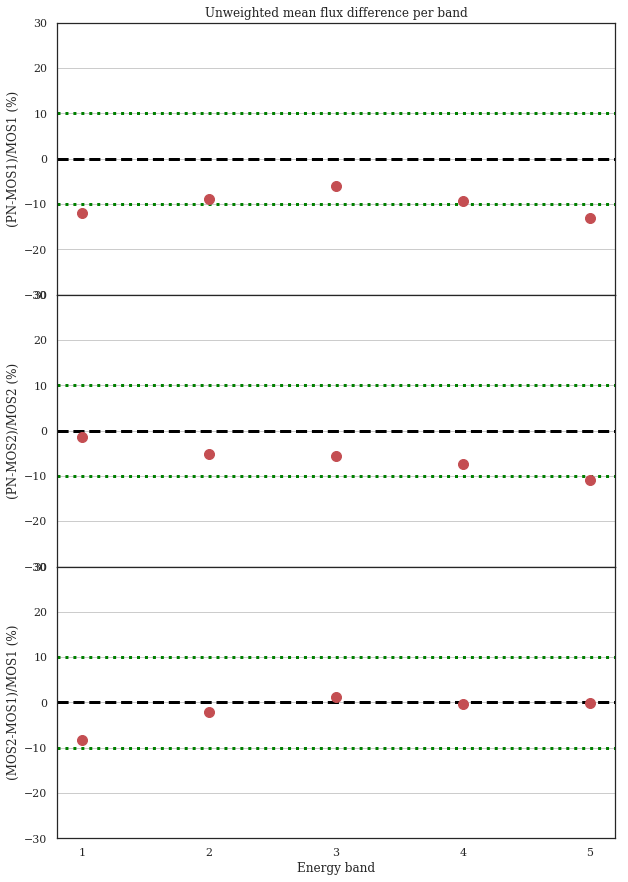

In [7]:
#
# per band plots of the flux diffs
#
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
#
xband = [1,2,3,4,5]
#
xmean1 = np.asarray([mean1[q] for q in mean1.keys()])
xlow1 = xmean1 - np.asarray([low1[q] for q in low1.keys()])
xup1 = np.asarray([up1[q] for q in up1.keys()]) - xmean1
xmean2 = np.asarray([mean2[q] for q in mean2.keys()])
xlow2 = xmean2 - np.asarray([low2[q] for q in low2.keys()])
xup2 = np.asarray([up2[q] for q in up2.keys()]) - xmean2
xmean3 = np.asarray([mean3[q] for q in mean3.keys()])
xlow3 = xmean3 - np.asarray([low3[q] for q in low3.keys()])
xup3 = np.asarray([up3[q] for q in up3.keys()]) - xmean3
#
#axs[0].errorbar(xband,xmed1,yerr=(xmed1-xlow1,xup1-xmed1),fmt='o',markersize=10)
axs[0].errorbar(xband,xmean1,yerr=(xlow1,xup1),fmt='ro',markersize=10)
axs[0].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[0].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[0].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[0].yaxis.grid()
#axs[irun].legend(loc=1)
axs[0].set_xlabel('Energy band')
axs[0].set_ylabel('(PN-MOS1)/MOS1 (%)')
axs[0].set_xticks(xband, minor=False)
axs[0].set_ylim((-30,30))
axs[0].set_title('Unweighted mean flux difference per band')
#
#axs[1].errorbar(xband,xmed2,yerr=(xmed2-xlow2,xup2-xmed2),fmt='o',markersize=10)
axs[1].errorbar(xband,xmean2,yerr=(xlow2,xup2),fmt='ro',markersize=10)
axs[1].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[1].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[1].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[1].yaxis.grid()
#axs[irun].legend(loc=1)
axs[1].set_xlabel('Energy band')
axs[1].set_ylabel('(PN-MOS2)/MOS2 (%)')
axs[1].set_xticks(xband, minor=False)
axs[1].set_ylim((-30,30))
#
#axs[2].errorbar(xband,xmed3,yerr=(xmed3-xlow3,xup3-xmed3),fmt='o',markersize=10)
axs[2].errorbar(xband,xmean3,yerr=(xlow3,xup3),fmt='ro',markersize=10)
axs[2].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[2].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[2].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[2].yaxis.grid()
#axs[irun].legend(loc=1)
axs[2].set_xlabel('Energy band')
axs[2].set_ylabel('(MOS2-MOS1)/MOS1 (%)')
axs[2].set_xticks(xband, minor=False);
axs[2].set_ylim((-30,30))
#
plt.subplots_adjust(wspace=0, hspace=0);

## Flux differences per band and epoch (revolution)

Will use the sub-catalogue per band `qtsel[xband]` and bin in epochs of 250 revolutions (as in Mateos et al. 2009).

/home/ivaltchanov/miniconda3/envs/pyxspec/lib/python3.6/site-packages/ipykernel_launcher.py:32: RuntimeWarning: divide by zero encountered in true_divide


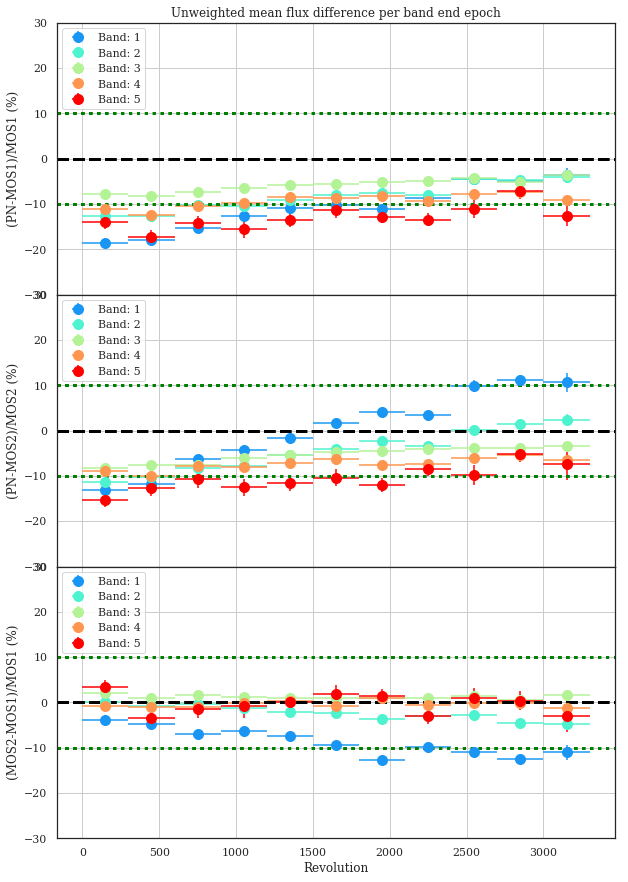

In [8]:
import matplotlib.cm as cm
#
#
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
#
xcol = cm.rainbow(np.linspace(0, 1, 6))

for xband in [1,2,3,4,5]:
    #
    epoch = [int(x) for x in qtsel[xband]['REVOLUT']]
    m1_fx = qtsel[xband][f'M1_{xband}_FLUX']
    m2_fx = qtsel[xband][f'M2_{xband}_FLUX']
    pn_fx = qtsel[xband][f'PN_{xband}_FLUX']
    #
    m1_fx_err = qtsel[xband][f'M1_{xband}_FLUX_ERR']
    m2_fx_err = qtsel[xband][f'M2_{xband}_FLUX_ERR']
    pn_fx_err = qtsel[xband][f'PN_{xband}_FLUX_ERR']
    #
    # now the ratios and their errors
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx/m1_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx/m2_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx/m1_fx_err)**2 + (m2_fx/m2_fx_err)**2)
    #
    # the weights as 1/sigma
    #
    w1 = 1.0/ratio1_err
    w2 = 1.0/ratio2_err
    w3 = 1.0/ratio3_err
    #
    # now loop over the epochs
    #
    rstep = 300.0
    run_epoch = np.arange(0,3500,rstep)
    nep = len(run_epoch)
    #
    xepo = []
    erat1 = []
    erat2 = []
    erat3 = []
    erat1_err = []
    erat2_err = []
    erat3_err = []
    #
    for j in np.arange(nep-1):
        e0 = run_epoch[j]
        e1 = run_epoch[j+1]
        ix = np.where((epoch <= e1) & (epoch > e0))[0]
        if (len(ix) > 0):
            xepo.append((e0+e1)/2.0)
            erat1.append(np.mean(ratio1[ix]))
            erat2.append(np.mean(ratio2[ix]))
            erat3.append(np.mean(ratio3[ix]))
            erat1_err.append(sem(ratio1[ix]))
            erat2_err.append(sem(ratio2[ix]))
            erat3_err.append(sem(ratio3[ix]))
        else:
            continue
    #
    neq = len(xepo)
#
    axs[0].errorbar(xepo,erat1,xerr=rstep/2.0,yerr=erat1_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    axs[0].axhline(0.0,color='black',linestyle='--',linewidth=3)
    axs[0].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
    axs[0].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
    axs[0].grid()
    axs[0].legend(loc='upper left')
    axs[0].set_xlabel('Energy band')
    axs[0].set_ylabel('(PN-MOS1)/MOS1 (%)')
    #axs[0].set_xticks(xband, minor=False)
    axs[0].set_ylim((-30,30))
    axs[0].set_title('Unweighted mean flux difference per band end epoch')
    #
    #axs[1].errorbar(xband,xmed2,yerr=(xmed2-xlow2,xup2-xmed2),fmt='o',markersize=10)
    axs[1].errorbar(xepo,erat2,xerr=rstep/2.0,yerr=erat2_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    axs[1].axhline(0.0,color='black',linestyle='--',linewidth=3)
    axs[1].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
    axs[1].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
    axs[1].grid()
    axs[1].legend(loc='upper left')
    axs[1].set_xlabel('Energy band')
    axs[1].set_ylabel('(PN-MOS2)/MOS2 (%)')
    #axs[1].set_xticks(xband, minor=False)
    axs[1].set_ylim((-30,30))
    #
    #axs[2].errorbar(xband,xmed3,yerr=(xmed3-xlow3,xup3-xmed3),fmt='o',markersize=10)
    axs[2].errorbar(xepo,erat3,xerr=rstep/2.0,yerr=erat3_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    axs[2].axhline(0.0,color='black',linestyle='--',linewidth=3)
    axs[2].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
    axs[2].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
    axs[2].grid()
    axs[2].legend(loc='upper left')
    axs[2].set_xlabel('Revolution')
    axs[2].set_ylabel('(MOS2-MOS1)/MOS1 (%)')
    #axs[2].set_xticks(xband, minor=False);
    axs[2].set_ylim((-30,30))
    #
plt.subplots_adjust(wspace=0, hspace=0);    

## Flux difference as a function of off-axis angle


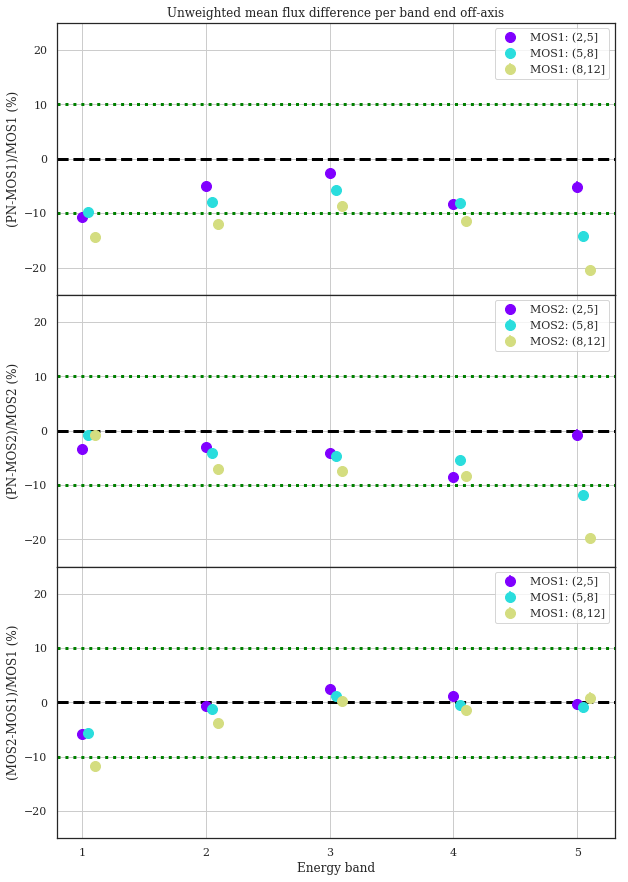

In [10]:
#
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
#

off = np.array([2.0,5.0,8.0,12.0])
noff = len(off)
bands = np.array([1,2,3,4,5])
xcol = cm.rainbow(np.linspace(0, 1, len(off-1)))
#
for j in np.arange(noff-1):
    x0 = off[j]
    x1 = off[j+1]
    tband = []
    erat1 = []
    erat2 = []
    erat3 = []
    erat1_err = []
    erat2_err = []
    erat3_err = []
    for xband in bands:
        #
        m1_off = qtsel[xband]['M1_OFFAX']
        m2_off = qtsel[xband]['M2_OFFAX']
        pn_off = qtsel[xband]['PN_OFFAX']
        #
        m1_fx = qtsel[xband][f'M1_{xband}_FLUX']
        m2_fx = qtsel[xband][f'M2_{xband}_FLUX']
        pn_fx = qtsel[xband][f'PN_{xband}_FLUX']
        #
        m1_fx_err = qtsel[xband][f'M1_{xband}_FLUX_ERR']
        m2_fx_err = qtsel[xband][f'M2_{xband}_FLUX_ERR']
        pn_fx_err = qtsel[xband][f'PN_{xband}_FLUX_ERR']
        #
        # now the ratios and their errors
        #
        ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
        ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx/m1_fx_err)**2 + (pn_fx/pn_fx_err)**2)
        ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
        ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx/m2_fx_err)**2 + (pn_fx/pn_fx_err)**2)
        ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
        ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx/m1_fx_err)**2 + (m2_fx/m2_fx_err)**2)
        #
        # now select over the offaxis angles
        #
        #ix = np.where((m1_off <= x1) & (m1_off > x0) & (m2_off <= x1) & (m2_off > x0) & (pn_off <= x1) & (pn_off > x0))[0]
        ix1 = np.where((m1_off <= x1) & (m1_off > x0))[0]
        ix2 = np.where((m2_off <= x1) & (m2_off > x0))[0]
        if (len(ix) > 0):
            tband.append(xband + 0.2*j/4.0)
            erat1.append(np.mean(ratio1[ix1]))
            erat2.append(np.mean(ratio2[ix2]))
            erat3.append(np.mean(ratio3[ix1]))
            erat1_err.append(sem(ratio1[ix1]))
            erat2_err.append(sem(ratio2[ix2]))
            erat3_err.append(sem(ratio3[ix1]))
            #
    axs[0].errorbar(tband,erat1,yerr=erat1_err,fmt='o',markersize=10,color=xcol[j],label=f'MOS1: ({x0:.0f},{x1:.0f}]')
    #
    #axs[1].errorbar(xband,xmed2,yerr=(xmed2-xlow2,xup2-xmed2),fmt='o',markersize=10)
    axs[1].errorbar(tband,erat2,yerr=erat2_err,fmt='o',markersize=10,color=xcol[j],label=f'MOS2: ({x0:.0f},{x1:.0f}]')
    #
    #axs[2].errorbar(xband,xmed3,yerr=(xmed3-xlow3,xup3-xmed3),fmt='o',markersize=10)
    axs[2].errorbar(tband,erat3,yerr=erat3_err,fmt='o',markersize=10,color=xcol[j],label=f'MOS1: ({x0:.0f},{x1:.0f}]')
    #
axs[0].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[0].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[0].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[0].grid()
axs[0].legend(loc='upper right')
axs[0].set_xlabel('Energy band')
axs[0].set_ylabel('(PN-MOS1)/MOS1 (%)')
axs[0].set_ylim((-25,25))
axs[0].set_title('Unweighted mean flux difference per band end off-axis')
#
axs[1].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[1].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[1].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[1].grid()
axs[1].legend(loc='upper right')
axs[1].set_xlabel('Energy band')
axs[1].set_ylabel('(PN-MOS2)/MOS2 (%)')
#axs[1].set_xticks(xband, minor=False)
axs[1].set_ylim((-25,25))
axs[2].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[2].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[2].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[2].grid()
axs[2].legend(loc='upper right')
axs[2].set_xlabel('Energy band')
axs[2].set_ylabel('(MOS2-MOS1)/MOS1 (%)')
#axs[2].set_xticks(xband, minor=False);
axs[2].set_ylim((-25,25))
#axs[0].set_xticks(xband, minor=False)
plt.subplots_adjust(wspace=0, hspace=0);    

## Flux difference as a function of the azymuthal angle

All flux diffs per band and M1 azymuth angle


In [22]:
t = Table.read(f'{wdir}/m1_vig_1000ev_3min.dat',format='ascii.fast_no_header')
# normalise to have max = 0 and convert to percantage
runphi = vig1_3['col1']
vig1_3 = (t['col2'] - np.max(t['col2']))*100.0
#
t = Table.read(f'{wdir}/m1_vig_10000ev_3min.dat',format='ascii.fast_no_header')
vig10_3 = (t['col2'] - np.max(t['col2']))*100.0
#
t = Table.read(f'{wdir}/m1_vig_1000ev_10min.dat',format='ascii.fast_no_header')
vig1_10 = (t['col2'] - np.max(t['col2']))*100.0
#
t = Table.read(f'{wdir}/m1_vig_10000ev_10min.dat',format='ascii.fast_no_header')
vig10_10 = (t['col2'] - np.max(t['col2']))*100.0


Band: 1, selected 4370 at M1_OFFAX >= 2 arcmin
Band: 2, selected 10797 at M1_OFFAX >= 2 arcmin
Band: 3, selected 15217 at M1_OFFAX >= 2 arcmin
Band: 4, selected 7491 at M1_OFFAX >= 2 arcmin
Band: 5, selected 1289 at M1_OFFAX >= 2 arcmin


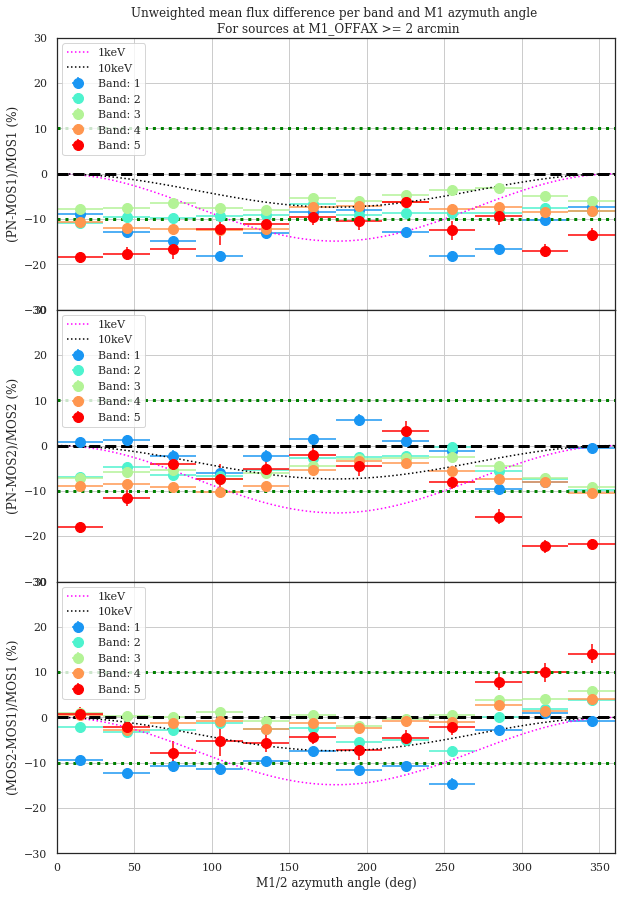

In [45]:
#
fig, axs = plt.subplots(3,1,figsize=(10,15),sharex=True)
#
# azymuthal angle ranges, step 30 deg
xazy = np.arange(0,390,30)
nz = len(xazy)
bands = np.array([1,2,3,4,5])
xcol = cm.rainbow(np.linspace(0, 1, 6))
#xcol = cm.rainbow(np.linspace(0, 1, nz-1))
#
# read the MOS vignetting functions from XMM-SAS calview, there are 4 curves: at 1 and 10 keV and at 3 arcmin and 10 arcmin
#
#
for xband in [1,2,3,4,5]:
    #
    # only select those sources at off-axis angles greater than 2 arcmin
    #
    m1_off = qtsel[xband][f'M1_OFFAX']
    qwork = qtsel[xband].to_pandas()
    qwork = qwork[m1_off >= 2.0]
    print (f"Band: {xband}, selected {len(qwork)} at M1_OFFAX >= 2 arcmin")
    #
    m1_az = qwork[f'M1_phi']
    m2_az = qwork[f'M2_phi']
    #
    m1_fx = qwork[f'M1_{xband}_FLUX']
    m2_fx = qwork[f'M2_{xband}_FLUX']
    pn_fx = qwork[f'PN_{xband}_FLUX']
    #
    m1_fx_err = qwork[f'M1_{xband}_FLUX_ERR']
    m2_fx_err = qwork[f'M2_{xband}_FLUX_ERR']
    pn_fx_err = qwork[f'PN_{xband}_FLUX_ERR']
    #
    # now the ratios and their errors
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio1_err = np.abs(ratio1)*np.sqrt((m1_fx/m1_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio2_err = np.abs(ratio2)*np.sqrt((m2_fx/m2_fx_err)**2 + (pn_fx/pn_fx_err)**2)
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    ratio3_err = np.abs(ratio3)*np.sqrt((m1_fx/m1_fx_err)**2 + (m2_fx/m2_fx_err)**2)
    #
    # now loop over the azymuths
    #
    rstep = 30.0
    run_az = np.arange(0,390,rstep)
    nep = len(run_az)
    #
    xaz1 = []
    xaz2 = []
    erat1 = []
    erat2 = []
    erat3 = []
    erat1_err = []
    erat2_err = []
    erat3_err = []
    #
    for j in np.arange(nep-1):
        e0 = run_az[j]
        e1 = run_az[j+1]
        ix1 = np.where((m1_az <= e1) & (m1_az > e0))[0]
        if (len(ix1) > 0):
            xaz1.append((e0+e1)/2.0)
            erat1.append(np.mean(ratio1[ix1]))
            erat3.append(np.mean(ratio3[ix1]))
            #erat1_err.append(np.std(ratio1[ix1]))
            #erat3_err.append(np.std(ratio3[ix1]))
            erat1_err.append(sem(ratio1[ix1]))
            erat3_err.append(sem(ratio3[ix1]))
        ix2 = np.where((m2_az <= e1) & (m2_az > e0))[0]
        if (len(ix2) > 0):
            xaz2.append((e0+e1)/2.0)
            erat2.append(np.mean(ratio2[ix2]))
            erat2_err.append(sem(ratio2[ix2]))
            #erat2_err.append(np.std(ratio2[ix2]))
    #
    neq = len(xepo)
#
    axs[0].errorbar(xaz1,erat1,xerr=rstep/2.0,yerr=erat1_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    #
    # now the vignetting function
    #
    #axs[1].errorbar(xband,xmed2,yerr=(xmed2-xlow2,xup2-xmed2),fmt='o',markersize=10)
    axs[1].errorbar(xaz2,erat2,xerr=rstep/2.0,yerr=erat2_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    #
    #axs[2].errorbar(xband,xmed3,yerr=(xmed3-xlow3,xup3-xmed3),fmt='o',markersize=10)
    axs[2].errorbar(xaz1,erat3,xerr=rstep/2.0,yerr=erat3_err,fmt='o',markersize=10,color=xcol[xband],label=f'Band: {xband}')
    #
#
# the MOS vignetting function from CCF/calview
#
axs[0].plot(runphi,vig1_10,color='magenta',linestyle='dotted',label="1keV")
axs[0].plot(runphi,vig10_10,color='black',linestyle='dotted',label="10keV")
#
axs[1].plot(runphi,vig1_10,color='magenta',linestyle='dotted',label="1keV")
axs[1].plot(runphi,vig10_10,color='black',linestyle='dotted',label="10keV")
#
axs[2].plot(runphi,vig1_10,color='magenta',linestyle='dotted',label="1keV")
axs[2].plot(runphi,vig10_10,color='black',linestyle='dotted',label="10keV")
###########
axs[0].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[0].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[0].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[0].grid()
axs[0].legend(loc='upper left')
axs[0].set_xlabel('Energy band')
axs[0].set_ylabel('(PN-MOS1)/MOS1 (%)')
#axs[0].set_xticks(xband, minor=False)
axs[0].set_ylim((-30,30))
axs[0].set_xlim((0,360))
axs[0].set_title('Unweighted mean flux difference per band and M1 azymuth angle \n For sources at M1_OFFAX >= 2 arcmin')
#
axs[1].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[1].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[1].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[1].grid()
axs[1].legend(loc='upper left')
axs[1].set_xlabel('Energy band')
axs[1].set_ylabel('(PN-MOS2)/MOS2 (%)')
#axs[1].set_xticks(xband, minor=False)
axs[1].set_ylim((-30,30))
axs[1].set_xlim((0,360))
#
axs[2].axhline(0.0,color='black',linestyle='--',linewidth=3)
axs[2].axhline(-10.0,color='green',linestyle='dotted',linewidth=3)
axs[2].axhline(10.0,color='green',linestyle='dotted',linewidth=3)
axs[2].grid()
axs[2].legend(loc='upper left')
axs[2].set_xlabel('M1/2 azymuth angle (deg)')
axs[2].set_ylabel('(MOS2-MOS1)/MOS1 (%)')
#axs[2].set_xticks(xband, minor=False);
axs[2].set_ylim((-30,30))
axs[2].set_xlim((0,360))
#
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig(f"{wdir}/3xmm_results_azymuth.png",dpi=100)
plt.show()
plt.close();

In [58]:
import math
sx = math.pi*(12*12-2*2)/4.0
math.sqrt(sx/math.pi + 10.44**2)

11.999733330370304

Doing radial bin 2.0 to 6.24 with mean 4.633443643770797
Doing radial bin 6.24 to 8.6 with mean 7.513241643924411
Doing radial bin 8.6 to 10.44 with mean 9.564350474548704
Doing radial bin 10.44 to 12.0 with mean 11.247079620950498


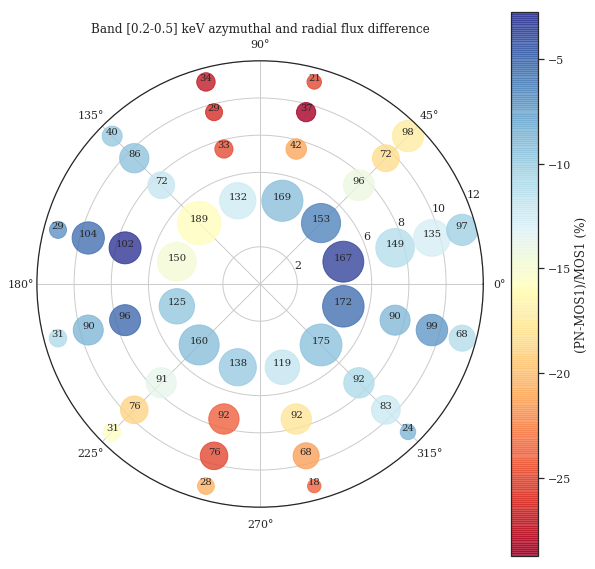

In [139]:
#
#
# polar plot for band=1 and azymuthal angles from 0 to 360 with step 30 deg and 
# 3 equal area offaxis bins from 2 to 12 arcmin.
#
rad_bins = np.array([2.0,6.24,8.60,10.44,12.0],dtype=np.float) # arcmin, equal area bins
nrad = len(rad_bins)
# azymuthal bins of 30 degrees
xazy = np.arange(0,390,30)
nz = len(xazy)
#
xband = 1

m1_off = qtsel[xband][f'M1_OFFAX']
qwork = qtsel[xband]

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='polar')

xaz = []
rrun = []
erat1 = []
#erat2 = []
#erat3 = []
erat1_err = []
ncounts = []
#erat2_err = []
#erat3_err = []
#

for ir in np.arange(nrad-1):
    r0 = rad_bins[ir]
    r1 = rad_bins[ir+1]
    rmean = math.sqrt((r1*r1 + r0*r0)/2.0)
    print (f"Doing radial bin {r0} to {r1} with mean {rmean}")
    qtemp = qwork[(m1_off >= r0) & (m1_off < r1)]
    #
    m1_az = qtemp[f'M1_phi']
    #
    m1_fx = qtemp[f'M1_{xband}_FLUX']
    m2_fx = qtemp[f'M2_{xband}_FLUX']
    pn_fx = qtemp[f'PN_{xband}_FLUX']
    #
    m1_fx_err = qtemp[f'M1_{xband}_FLUX_ERR']
    m2_fx_err = qtemp[f'M2_{xband}_FLUX_ERR']
    pn_fx_err = qtemp[f'PN_{xband}_FLUX_ERR']
    #
    # now the ratios
    #
    ratio1 = (pn_fx/m1_fx - 1.0)*100.0 # in percents
    ratio2 = (pn_fx/m2_fx - 1.0)*100.0 # in percents
    ratio3 = (m2_fx/m1_fx - 1.0)*100.0 # in percents
    #
    # now loop over the azymuths
    #
    #
    for iz in np.arange(nz-1):
        z0 = xazy[iz]
        z1 = xazy[iz+1]
        ix1 = np.where((m1_az <= z1) & (m1_az > z0))[0]
        if (len(ix1) > 0):
            xaz.append((z0+z1)/2.0)
            rrun.append(rmean)
            erat1.append(np.mean(ratio1[ix1]))
            erat1_err.append(sem(ratio1[ix1]))
            ncounts.append(len(ix1))
        else:
            continue
    #
theta = np.array(xaz)*math.pi/180.0 # in radians
colors = erat1
#area = 10*np.array(rrun)**2
area = 10*np.array(ncounts)
cm = plt.cm.get_cmap('RdYlBu')
p1 = ax.scatter(theta,rrun,c=colors,cmap=cm,s=area,alpha=0.8)
#ax.set_yticklabels([])
ax.set_yticks([2.0,6,8.0,10.0,12.0])
ax.set_ylim((0,12))
ax.set_title(f'Band {bands[xband]} azymuthal and radial flux difference')
cbar = plt.colorbar(p1)
cbar.set_label('(PN-MOS1)/MOS1 (%)');
#
# label points with number of sources
ntx = len(theta)
for ij in np.arange(ntx):
    plt.text(theta[ij], rrun[ij], f"{ncounts[ij]}",
             horizontalalignment='center',
             verticalalignment='bottom')


In [83]:
math.sqrt((8.60**2 - 6.24**2)/2.0)

4.184638574596376